Brain states transitions in response to working memory training
==================================================================

Analyses performed by Karolina Finc & Justyna Kuk, 
*Centre for Modern interdisciplinary Technologies, Nicolaus Copernicus University in Toruń*

Last edited: 08-07-2019

--------------

The goal of this analysis is to examine the effects of working memory training on *time-resolved brain state dynamics* examined in the trained task and the resting-state. Does working memory training affects brain state distribution in the task? 

We used unsupervised machine learning approach to cluster dual n-back and resting-state fMRI time-series into discrete brain states (see Chen et al., 2015; Cornblath et al., 2018). We hypothesize that:
- The brain states fluctuation will differ after working memory training especially in the states related to default mode and frontoparietal systems activity. 
- Training-related changes in brain states dynamics will be more visible during the trained task than the resting state.
- Individual characteristics of brain states fluctuations will be associated to individual behavioral differences in training progress.


Step 1: Timeseries preparation
----------

Prior to running clustering the time-series into discrete brain stets, all timeseries were concatenated into large $N \times P$ array containing $N$ observation and $P$ features. The length of $N$ was equal to 227040 as a result of concatenating 4 sessions of dual n-back data (340 time-points) and resting state data (305 time-points) of 44 subjects. The length of $P$ was equal 400 and represented the mean signal extracted from each brain areas of Schaefer et al. (2019) brain parcellation.

By this procedure we ensured the correspondence of brain states labels across subjects, sessions and tasks.

(for now, we just testing code on small subsample of dataset -- 8 subjects)

In [9]:
import numpy as np

# Loading time-series data
ts_dualnback = np.load("timeseries_schaefer400_dualnback.npy")
ts_rest = np.load("timeseries_schaefer400_rest.npy")

n_sub = 8 # Select number of subjects 
ts_dualnback = ts_dualnback[:n_sub]
ts_rest = ts_rest[:n_sub]

print(f'Original dualnback data shape: {ts_dualnback.shape}')
print(f'Original dualnback data shape: {ts_rest.shape}')

Original dualnback data shape: (8, 4, 340, 400)
Original dualnback data shape: (8, 4, 305, 400)


In [10]:
# Concatenating time-series
n_ses = ts_dualnback.shape[1]
n_rois = ts_dualnback.shape[3]

cts_dualnback = ts_dualnback.reshape(n_sub*n_ses*ts_dualnback.shape[2], n_rois)     #all 46 subcjects in one vector
cts_rest = ts_rest.reshape(n_sub*n_ses*ts_rest.shape[2], n_rois)

# Concatenating task and rest
cts_all = np.zeros((cts_dualnback.shape[0] + cts_rest.shape[0] , n_rois))
cts_all[0:cts_dualnback.shape[0],:] = cts_dualnback 
cts_all[cts_dualnback.shape[0]:, :] = cts_rest

print(f'Shape of dualnback timeseries: {cts_dualnback.shape}')
print(f'Shape of rest timeseries: {cts_rest.shape}')
print(f'Shape of all timeseries: {cts_all.shape}')

Shape of dualnback timeseries: (10880, 400)
Shape of rest timeseries: (9760, 400)
Shape of all timeseries: (20640, 400)


Step 2: Clustering the timeseries into brain states
----------------------

To discover main brain states existing in time-series we performed 500 repetitions of $k$-means clustering from $k$ = 2 to $k$ = 18 using Euclidean distance as a measure of similarity. 

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

max_k = 18
brain_states = np.zeros((max_k-1,cts_all.shape[0]))
silhouette = np.zeros((max_k-1))

for k in range(max_k-1):
    print(f'Clustering for k = {k+2}')
    kmeans = KMeans(n_clusters=k+2, n_init=10).fit(cts_all) # Change to 500 later
    kmeans_predict = kmeans.fit_predict(cts_all)
    brain_states[k,:] = kmeans.labels_
    silhouette[k] = silhouette_score(cts_all, kmeans_predict)
    
np.save("brain_states.npy", brain_states)
np.save("silhouette_score.npy", silhouette)

Clustering for k = 2
Clustering for k = 3
Clustering for k = 4
Clustering for k = 5
Clustering for k = 6
Clustering for k = 7
Clustering for k = 8
Clustering for k = 9
Clustering for k = 10
Clustering for k = 11
Clustering for k = 12
Clustering for k = 13
Clustering for k = 14
Clustering for k = 15
Clustering for k = 16
Clustering for k = 17
Clustering for k = 18


Step 3: Selecting k size based on silhouette score and absent states
-------------------------------------------------------------------------
To identify the optimal number of clusters we use silhouette score.

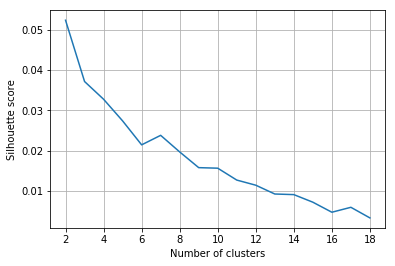

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting Silhouette score
plt.plot(np.arange(2,19), silhouette)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [7]:
brain_states.shape

(17, 20640)

In [11]:
import numpy as np

brain_states = np.load('brain_states.npy')

bs_dualnback = brain_states[:, :cts_dualnback.shape[0]]
bs_rest = brain_states[:, cts_dualnback.shape[0]:]

sub_ses_bs_dualnback = bs_dualnback.reshape(brain_states.shape[0], ts_dualnback.shape[2], n_sub, n_ses)
sub_ses_bs_rest = bs_rest.reshape(brain_states.shape[0], ts_rest.shape[2], n_sub, n_ses)

print(sub_ses_bs_dualnback.shape)
print(sub_ses_bs_rest.shape)

(17, 340, 8, 4)
(17, 305, 8, 4)


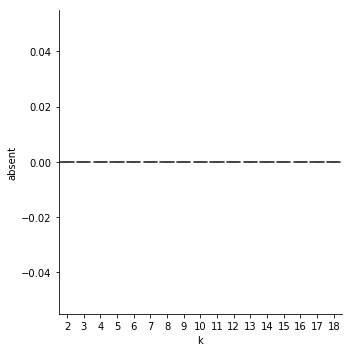

In [138]:
import numpy as np
from functions import absent_states
import seaborn as sns

absent_states = absent_states(sub_ses_bs_dualnback)
absent_states.head()

sns.catplot(x='k', y='absent', data=absent_states, kind = 'box')


Step 4: Split-halves validation for k = 5
-------------------------------------------------------------------------

We also split our sample into two equal partitions 500 times and performed k-means clustering separately on each half of the dataset. We then matched clusters by computing the correlation between both sets of centroids, and then by reordering the clusters based on the maximum correlation value for each cluster.

In [ ]:
# from sklearn.model_selection import train_test_split

# dim = int(t_vector.shape[0]/2)
# train_series = np.zeros((500,dim,264))
# test_series = np.zeros((500,dim,264))

# for i in range(500):
#     X_train, X_test = train_test_split(t_vector, test_size=0.5)
#     train_series[i,:,:] = X_train
#     test_series[i,:,:] = X_test

In [ ]:
# from sklearn.cluster import KMeans
# import pandas as pd
# from scipy.stats import pearsonr

# n_clusters = 6

# cor = np.zeros((500,n_clusters,n_clusters))

# for sub in range(500):
#     train_kmeans = KMeans(n_clusters=n_clusters, n_init=500).fit(train_series[sub,:,:])
#     test_kmeans = KMeans(n_clusters=n_clusters, n_init=500).fit(test_series[sub,:,:])
#     x = train_kmeans.cluster_centers_
#     y = test_kmeans.cluster_centers_
#     for k in range(n_clusters):
#         for j in range(n_clusters):
#             cor[sub,k,j] = pearsonr(x[k],y[j])[0]

In [ ]:
# cor_sort = np.sort(cor)
# max_values = np.zeros((500,n_clusters))

# for i in range(500):
#     max_values = cor_sort[i,:,-1]
#     mean_max_values = (cor_sort[i,:,-1]).mean


In [ ]:
# from nilearn import plotting

# num = 0

# print(cor_sort[num,:,-1])
# plotting.plot_matrix(cor_sort[num,:,:])

Step 5: Correlating cluster labels with well-known large-scale networks
-------------------------------------------------------------------------

To describe the pattern of brain dynamics characteristic for each brain state, we averaged timeseries across each cluster and calculated Pearson's correlation of resulting 400-element vector (mean activity within each parcel from Schaefer parcellation) with binary vectors representing *a priori* defined 7-network partition (Schaefer, et al. 2018).

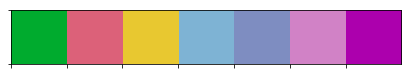

In [101]:
from nilearn import datasets
from nilearn.plotting import plot_roi
import seaborn as sns
%matplotlib inline

# Getting a priori defined 7-network partition's label 
schaefer400 = datasets.fetch_atlas_schaefer_2018(n_rois=400, 
                                           yeo_networks=7, 
                                           resolution_mm=1,
                                           data_dir=None, 
                                           base_url=None, 
                                           resume=True, 
                                           verbose=1)

# Dictionary to create network's abbreviations
schaefer_dict = {
    "Vis": "VIS",
    "SomMot": "SOM",
    "DorsAttn": "DAN",
    "Sal": "VAN",
    "Limbic": "LIM",
    "Cont": "FPN",
    "Default": "DMN"
}

networks = [val for key, val in schaefer_dict.items() for roi in schaefer400['labels'] if key in roi.decode('UTF-8')]

# Creating color palette for netorks
schaefer_colors = {'DAN':'#00ab2e', 
                   'DMN':'#dc6179', 
                   'FPN':'#e8c830',
                   'LIM':'#7eb3d4', 
                   'SOM':'#7e8dc1', 
                   'VAN':'#d182c6',
                   'VIS':'#ac00ad',}

network_pal = (sns.color_palette(schaefer_colors.values()))
sns.palplot(network_pal)

In [149]:
import pandas as pd

states_no = 5
k_brain_states = brain_states[states_no-2]

# Creating data frame with dummy codes for each brain state
brain_states_filter = pd.get_dummies(k_brain_states)
brain_states_filter.columns = np.arange(1,states_no+1)

# Getting mean brain states timeseries
mean_brain_states = np.zeros((states_no,400))
for i, col in enumerate(brain_states_filter):
    state_filter = brain_states_filter[col].values.astype(bool)
    mean_brain_states[i] = cts_all[state_filter].mean(axis=0)
    
mean_brain_states.shape

(5, 400)

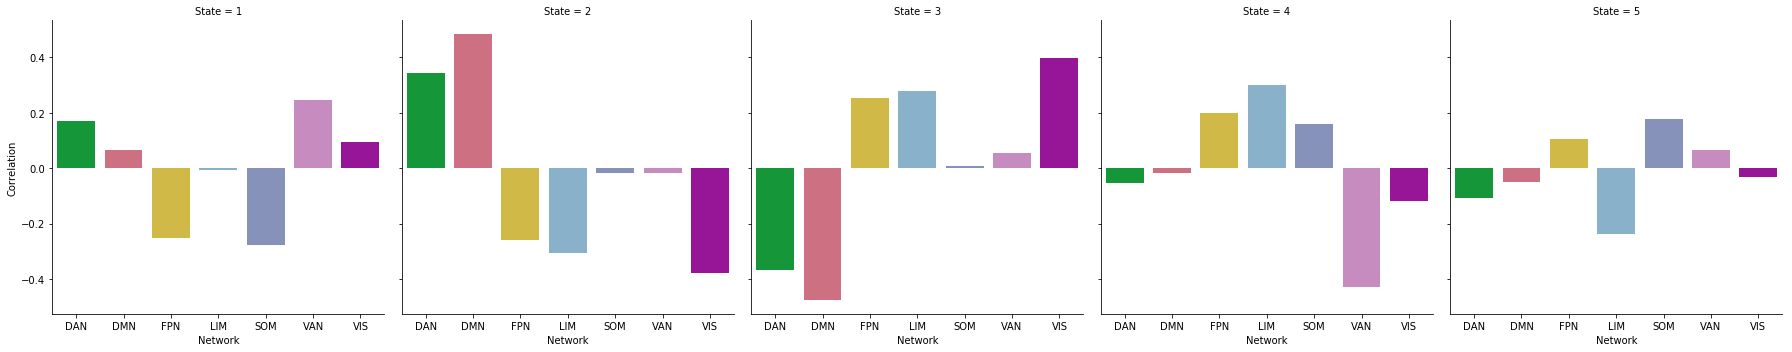

In [150]:
# Creating data frame with dummy codes for each network
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

networks_binary = pd.get_dummies(networks)
networks_correlations = pd.DataFrame()

for k in range(states_no):
    for j, net in enumerate(networks_binary.columns):
        cor = pearsonr(mean_brain_states[k], networks_binary.iloc[:,j].values)[0]
        networks_correlations = pd.concat([networks_correlations, pd.DataFrame({"State":k+1, "Network": net, "Correlation": cor},
                                                                               index=[0])], 
                                          axis=0)
        
        
sns.catplot(x='Network', y='Correlation', col='State', kind='bar', data=networks_correlations, palette=network_pal)

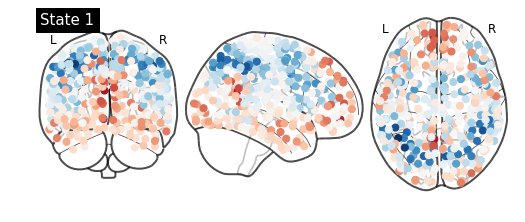

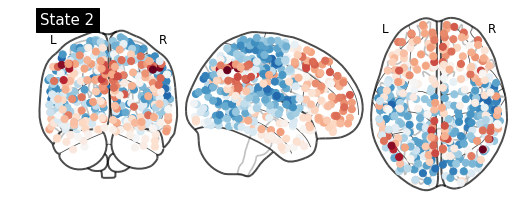

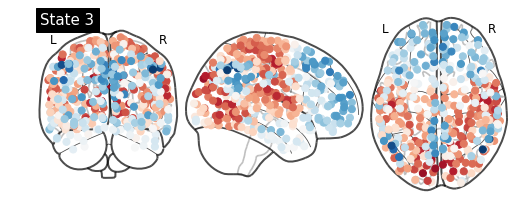

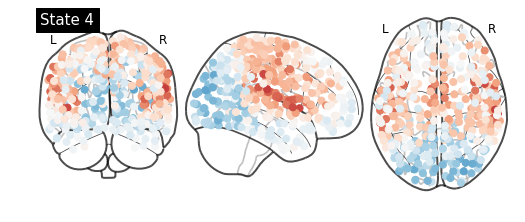

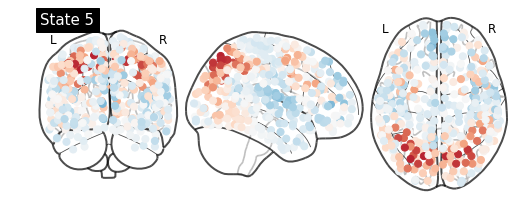

In [376]:
schaefer_coord = pd.read_csv("Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.Centroid_RAS.csv")
schaefer_coord = np.stack((schaefer_coord.iloc[1:, 2], schaefer_coord.iloc[1:, 3], schaefer_coord.iloc[1:, 4])).T

norm = plt.Normalize(vmin=mean_brain_states.min(), vmax=mean_brain_states.max())

for i in range(5):
    colors = plt.cm.RdBu_r(norm(mean_brain_states[i]))
    plotting.plot_connectome(np.zeros((400,400)), schaefer_coord, node_color = colors, title=f"State {i+1}")

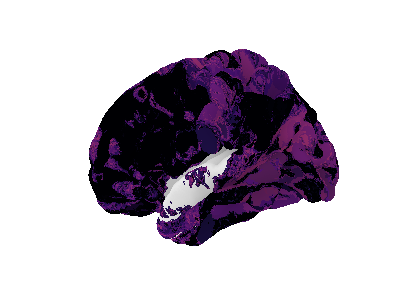

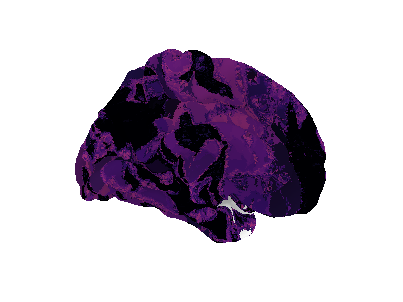

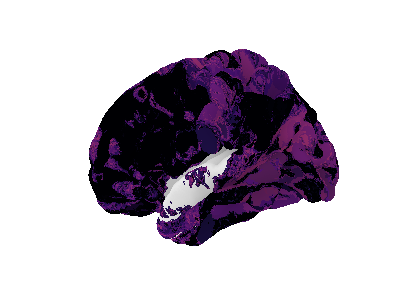

In [377]:
# Surface plots of the mean brain states
import matplotlib as mpl
from nilearn import surface
from nilearn import plotting

schaefer400_maps = schaefer400['maps']
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
texture = surface.vol_to_surf(schaefer400_maps, fsaverage.pial_right)

colors = plt.cm.magma(mean_brain_states[2])
cmap = plt.cm.magma
cmaplist = colors

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=texture,
                       hemi='left', view='medial',
                       bg_map=fsaverage['sulc_left'], bg_on_data=True,
                       cmap = cmap,
                       darkness=.5)

plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=texture,
                       hemi='left', view='lateral',
                       bg_map=fsaverage['sulc_left'], bg_on_data=True,
                       cmap = cmap,
                       darkness=.5)

Step 5: Calculating persistence probablilities, transition probablilities, dwell times for each subject/session
-------------------------------------------------------------------------

We calculated several measures using brain states labels, to to better describe brain states dynamics. 
For each subject, session, and task we calculated state's: 

- **dwell times** - percentage of timepoints in each run classified as specific state
- **transition probability** - probability of the transition from state $i$ to state $j$ given the current state $i$ divided by the sum of occurencies of $i$, resulting in $S\times S$ probability matrix $P_{ij}$, where S is equal to number of examined states.
- **persistence probability** - probability of the remaining in the same state. Diagonal elements of $P_{ij}$.

In [282]:
# Dwell time
tasks = {'dualnback': sub_ses_bs_dualnback[states_no-2, :, :, :], 'rest': sub_ses_bs_rest[states_no-2, :, :, :]}
dwell_times = pd.DataFrame()

for task, bs in tasks.items():
    for sub in range(bs.shape[1]):
        for ses in range(bs.shape[2]):
            dwell_time = np.unique(bs[:, sub, ses], return_counts=True)[1]/bs.shape[0]
            for state in range(states_no):
                dwell_times = pd.concat([dwell_times, pd.DataFrame({"Subject": f"sub-{sub+1:02}",
                                                                    "Session": f"ses-{ses+1}",
                                                                    "Task": task,
                                                                    "State": state+1,
                                                                    "Dwell_time": dwell_time[state]},
                                                                      index=[0])], 
                                              axis=0)


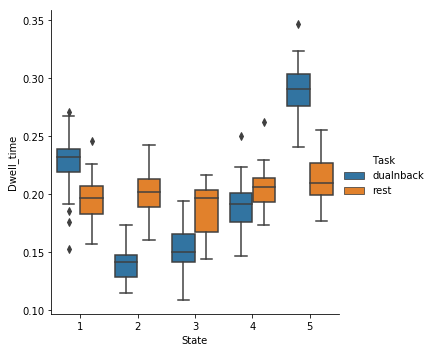

In [299]:
sns.catplot(x='State', y='Dwell_time', hue='Task', data = dwell_times, kind = 'box')

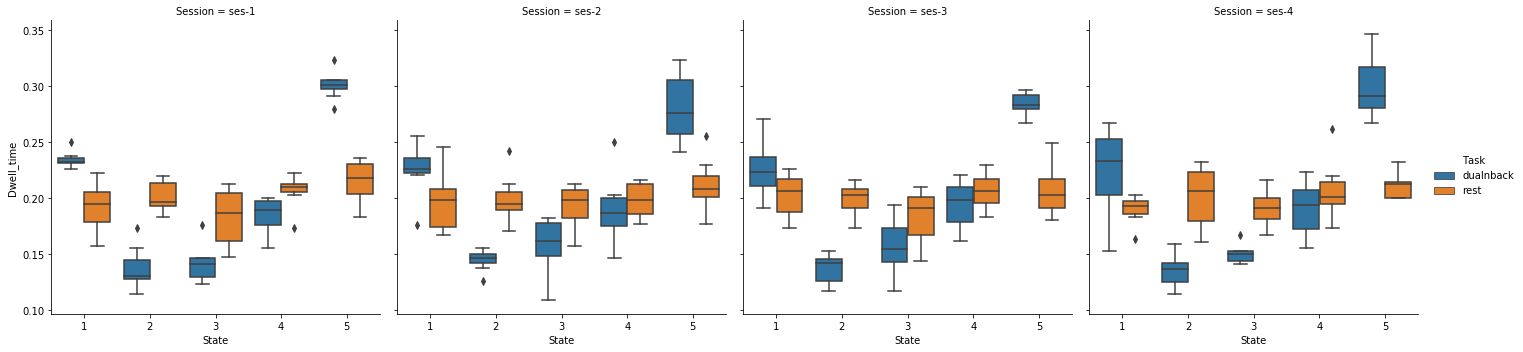

In [296]:
sns.catplot(x='State', y='Dwell_time', hue='Task', col='Session', data = dwell_times, kind = 'box')

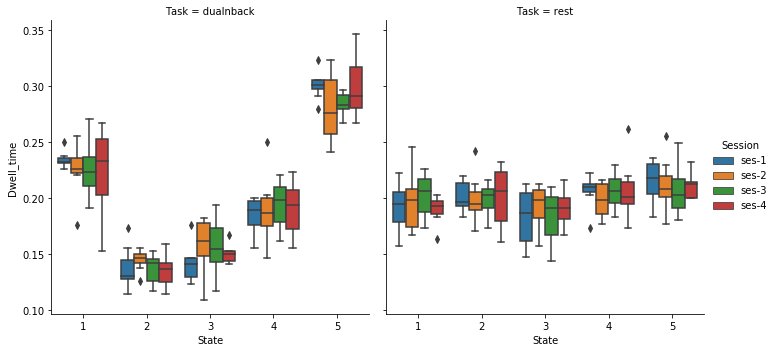

In [294]:
sns.catplot(x='State', y='Dwell_time', hue='Session', col='Task', data = dwell_times, kind = 'box')

In [318]:
from nilearn import plotting

bs = sub_ses_bs_dualnback[states_no-2, :, :, :]

#def states_transitions(bs, states_no):
state_transitions = np.zeros((bs.shape[1], bs.shape[2], states_no, states_no))

for sub in range(bs.shape[1]):
    for ses in range(bs.shape[2]):    
        for i in range(states_no):
            for j in range(states_no):
                count = 0
                for l in range(bs.shape[0]-1):
                    if bs[l, sub, ses]==i and bs[l+1, sub, ses]==j:
                        count += 1
                        p = count#/(bs.shape[0]-1)#np.unique(bs[:,sub,ses], return_counts=True)[1][i]
                state_transitions[sub, ses, i, j] = p
                #return state_transitions



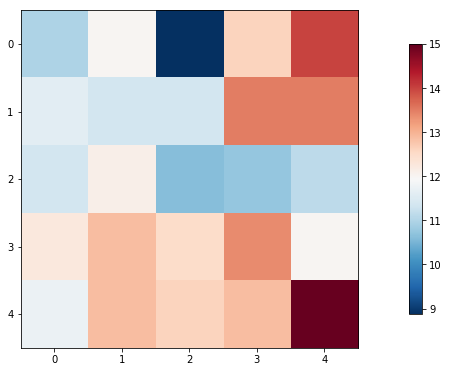

In [310]:
from nilearn.plotting import plot_matrix
plot_matrix(state_transitions.mean(axis=0)[0])

Step 6: Groups/sessions comparison
-------------------------------------------------------------------------
Description

In [ ]:
# Code here